In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator


from sklearn import linear_model

device = 'cuda:3'


truncate_circle = False

Load the Modes and the derivatives

In [2]:
microlens = 20 #20x20
size = microlens

n_zernike_rows = 4
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

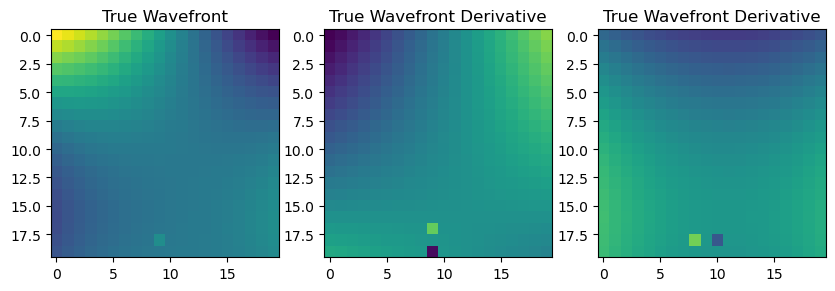

In [3]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2]

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(3,n_zernike)
np.random.shuffle(elements)
elements = elements[:3]
zer_coeffs = torch.randn(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs
# mode_coeffs[n_zernike] = 1 #vortex

mode_coeffs[380] = 1

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1); ax[2].set_title('True Wavefront Derivative')

## From here I show once we have gradients


In [4]:
sampled_gradient = wavefront_deriv.clone()
sampled_gradient[:,10,10] = np.nan

sampled_gradient+=torch.randn_like(sampled_gradient)*0.01 * torch.max(torch.nan_to_num(sampled_gradient))

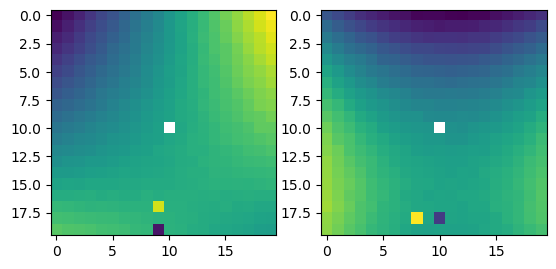

In [5]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sampled_gradient[0])
ax[1].imshow(sampled_gradient[1])

In [6]:
t = sampled_gradient.reshape(-1,1)
u = mode_derivs.permute(0,2,3,1).reshape(-1,mode_derivs.shape[1])

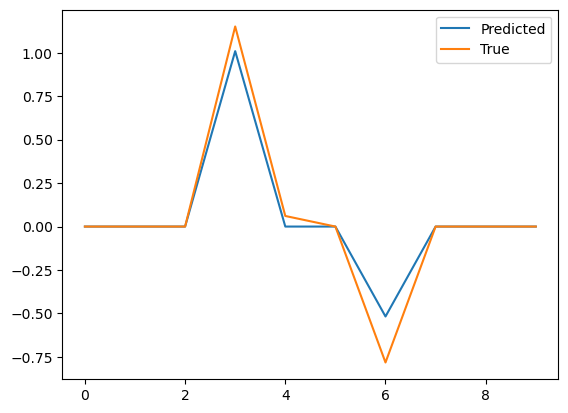

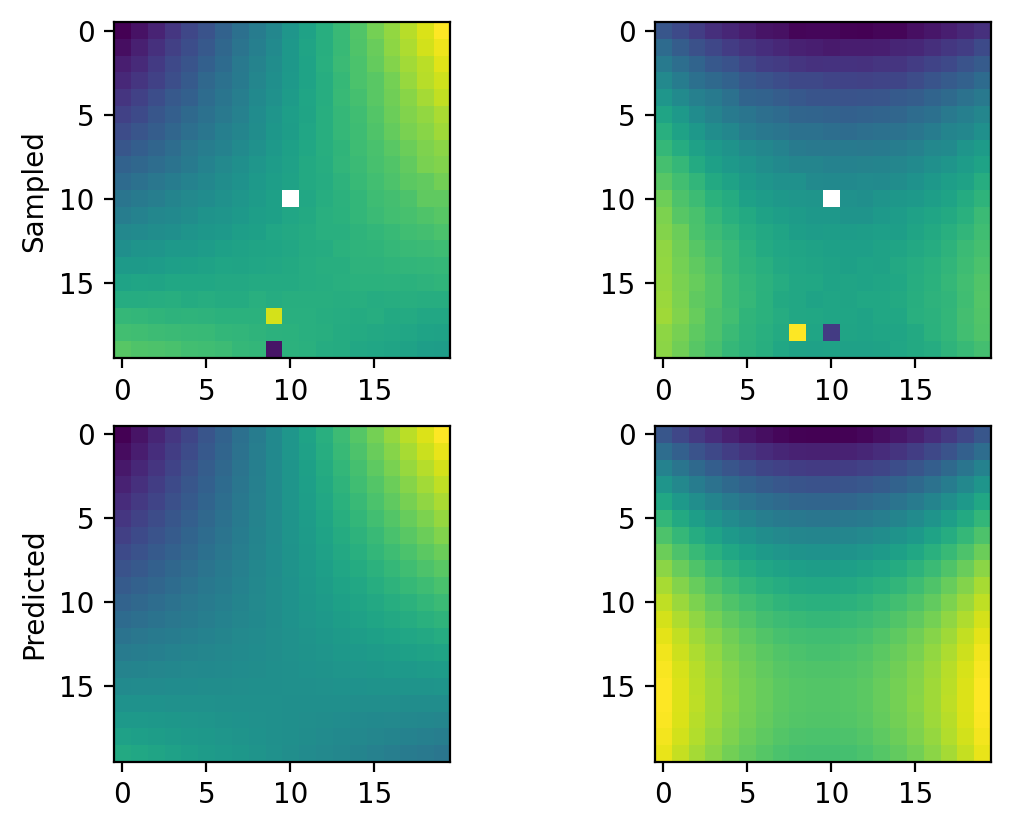

In [7]:
fit_modes, fit_mode_derivs = get_modes_and_derivs([0.,0.], xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)

wavefront_grad_prediction, result_vector = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.01)

fig,ax = plt.subplots(1,1)
ax.plot(result_vector[:n_zernike])
ax.plot(mode_coeffs[:n_zernike,0,0])
ax.legend(['Predicted','True'])

fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(wavefront_grad_prediction[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction[1])


In [8]:
%%timeit

wavefront_grad_prediction, result_vector = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.01)


2.79 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
